# Deep Reinforcement Learning: Tennis

---

This notebook demonstrates multi-agent

### 1. Start the Environment

We begin by importing the necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="simulation/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. It's Your Turn!

In [6]:
from models import Actor, Critic
from agents import Agent

In [7]:
env_info = env.reset(train_mode=True)[brain_name]
agent = Agent(state_size=len(env_info.vector_observations[0]), action_size=brain.vector_action_space_size, num_agents=num_agents , random_seed=2)

In [8]:
target_score = 0.5

def ddpg(n_episodes=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_window = deque(maxlen=100)  # last 100 scores
    scores = []
    average_score = []                 # List for average score of 100 episodes
    best_score_window = 0
    
    for i_episode in range(1, n_episodes+1):
        states = env.reset(train_mode=True)[brain_name].vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards

            next_states = env_info.vector_observations
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += env_info.rewards
            if np.any(dones):
                break 
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        scores_window.append(np.max(score))
        average_score.append(np.mean(scores_window))

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        if np.mean(scores_window)>=target_score and np.mean(scores_window)>best_score_window:
            print('\rDONE: Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            best_score_window = np.mean(scores_window)
            torch.save(agent.actor_local.state_dict(), 'best_checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'best_checkpoint_critic.pth')
        if np.mean(scores_window)>=target_score and np.mean(scores_window)<best_score_window:
            break
        
    return scores, average_score

In [9]:
scores, average_score = ddpg()

C:\Users\Sebas\miniconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.11
Episode 500	Average Score: 0.51
Episode 504	Average Score: 0.53: 0.54

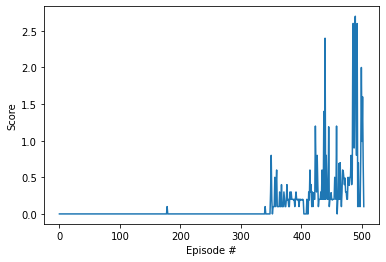

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

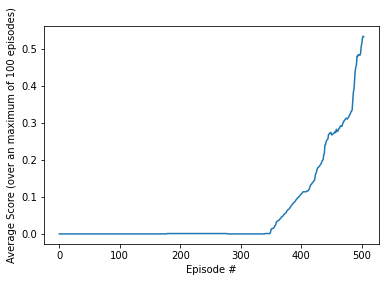

In [11]:
# plot the average scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(average_score)), average_score)
plt.ylabel('Average Score (over an maximum of 100 episodes)')
plt.xlabel('Episode #')
plt.show()

### 5. Demonstration

In [12]:
agent.actor_local.load_state_dict(torch.load('best_checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('best_checkpoint_critic.pth'))

<All keys matched successfully>

In [13]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

C:\Users\Sebas\miniconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Score (max over agents) from episode 1: 0.30000000447034836
Score (max over agents) from episode 2: 0.20000000298023224
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 1.3000000193715096


### 6. Shutdown

When finished, you can close the environment.

In [14]:
env.close()